In [1]:
# Importing Libraries
import pandas as pd
import glob
from nltk.corpus import stopwords 
from nltk.tokenize import RegexpTokenizer
import numpy as np
from gensim.models import Word2Vec

In [2]:
# Load the first 100 positive review text files
pos_review = (glob.glob(r"...\pos\*.txt"))[0:100]

# Read each file and append its content to a list
lines_pos = []
for i in pos_review:
    try:
        f = open(i, 'r')
        temp = f.readlines()[0]
        lines_pos.append(temp)
        f.close()
    except Exception as e:
        continue

In [3]:
# Tokenizer to extract words
tokenizer = RegexpTokenizer('[\w]+')

# Load English stopwords
stop_words = stopwords.words('english')

In [4]:
# Process each review into a list of word lists (sentences).
text = []

for line in lines_pos:
    words =  line.lower()
    tokens = tokenizer.tokenize(words)
    stopped_tokens = [i for i in list(set(tokens)) if not i in stop_words+["br"]]
    stopped_tokens2 = [i for i in stopped_tokens if len(i)>1]
    text.append(stopped_tokens2)

### Training the Word2Vec Model

In [5]:
# Train the Word2Vec model.
model = Word2Vec(text, 
                 vector_size=100, 
                 window=2, 
                 min_count=3, 
                 sg=1)

- <span style="font-size:15px">**vector_size=100**: Each word → 100-dimensional semantic vector.
- <span style="font-size:15px">**window=2**: Considers 2 words before/after the target word.
- <span style="font-size:15px">**min_count=3**: Ignores words appearing <3 times (filters noise/rare words).
- <span style="font-size:15px">**sg=1**: Skip-Gram; predicts context from target word, good for rare words.

In [6]:
# Optimize the trained Word2Vec model for memory usage.
model.init_sims(replace=True)

C:\Users\dadab\AppData\Local\Temp\ipykernel_15272\3929300770.py:2: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.init_sims(replace=True)


As the warning indicates, init_sims() is deprecated in newer versions of Gensim (4.0.0 and later). The library now handles memory optimization automatically after training, so **we no longer need to call that function**.

In [7]:
# Get the word vectors
word_vectors = model.wv

# See the shape of the vector matrix
word_vectors.vectors.shape

(895, 100)

In [8]:
# See the vocabulary
word_vectors.index_to_key[:10]

['movie',
 'film',
 'story',
 'one',
 'good',
 'see',
 'like',
 'well',
 'time',
 'much']

In [9]:
# Get the vector for a specific word
movie_vector = word_vectors['movie']
movie_vector

array([-0.05642349,  0.06567792,  0.0845389 ,  0.07541305, -0.03894034,
       -0.21772048,  0.03958846,  0.29309088, -0.07839578, -0.07436385,
       -0.03014521, -0.16999467, -0.03639762,  0.07265846, -0.04256114,
       -0.06510904,  0.05497376, -0.1231924 , -0.04600953, -0.26387113,
        0.09585129,  0.10574435,  0.03742199, -0.01561286, -0.03731347,
       -0.03682885, -0.07820924, -0.06027274, -0.08173342, -0.00887301,
        0.06817628,  0.05355481,  0.08506971, -0.06176791, -0.11487167,
        0.0830461 ,  0.04104262, -0.18851553, -0.10447446, -0.23278968,
       -0.01621372, -0.01831586, -0.1163791 , -0.06735457,  0.08804773,
       -0.05068028, -0.11897887,  0.03940716,  0.08965541,  0.10727865,
        0.01039024, -0.07547171, -0.06881217,  0.04490372, -0.02843256,
        0.02672538,  0.0856836 , -0.05130607, -0.12635718,  0.07788532,
        0.01375583,  0.05353338, -0.06941582, -0.11014289, -0.16124734,
        0.05950703,  0.04638879,  0.1009371 , -0.170948  ,  0.07

In [10]:
# similarity(): Computes the cosine similarity between two specific words.
model.wv.similarity('film', 'movie')

0.843358

In [11]:
# doesnt_match(): Given a list of words, it finds the one that is the least similar to the others
model.wv.doesnt_match(['film', 'movie', 'story', 'creepy'])

'creepy'

### Network graph based on Word2Vec model

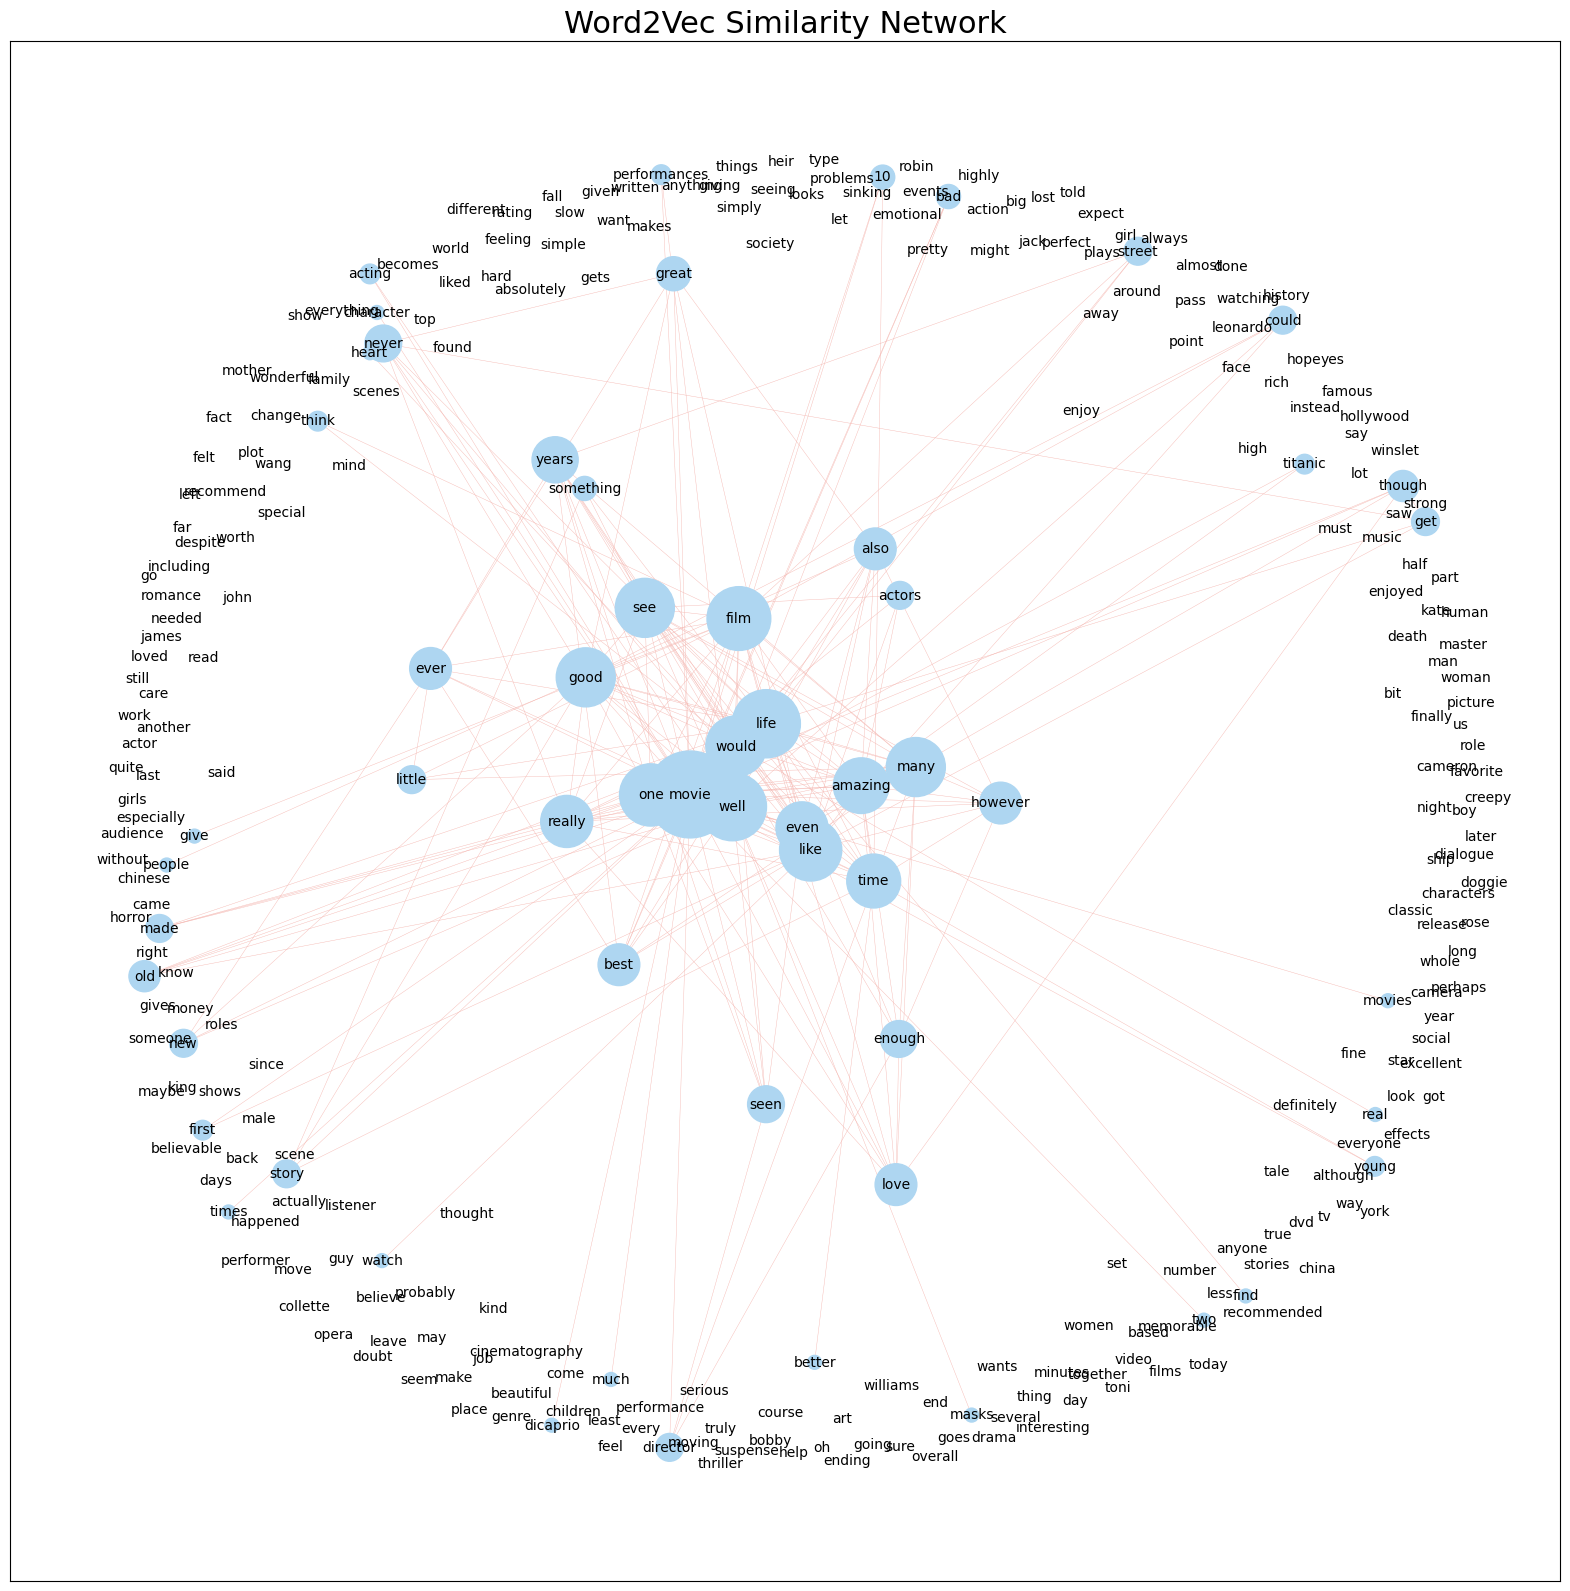

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
 
# Get the first 300 most frequent words from the model's vocabulary.
vocab = list(model.wv.index_to_key)[0:300]

# Create an empty graph object.
G = nx.Graph()
# Add every word from the 'vocab' list as a node in the graph.
G.add_nodes_from(vocab)
 
# Set a similarity threshold. Only strong connections will be drawn.
threshold = 0.8
# Loop through every possible pair of words in the vocabulary.
for i in range(len(vocab)):
    for j in range(i + 1, len(vocab)):
        # Check if the cosine similarity between two words is above the threshold.
        if model.wv.similarity(vocab[i], vocab[j]) > threshold:
            # If they are similar enough, create an edge connecting them.
            G.add_edge(vocab[i], vocab[j])
 
# Calculate node sizes based on their number of connections (degree centrality).
# More connected nodes will be larger.
degree_centrality = nx.degree_centrality(G)
node_size = [v * 30000 for v in degree_centrality.values()]
 
# Set the size of the output figure.
plt.figure(figsize=(20, 20))
# Use the spring_layout algorithm to position nodes.
# A higher 'k' value creates more space between nodes.
pos = nx.spring_layout(G, k=0.9, iterations=50, seed=42)

# Draw the network with specified styles.
nx.draw_networkx(
    G,
    pos,
    with_labels=True,      # Show the word labels.
    node_size=node_size,   # Set the size of each node.
    node_color="#AED6F1",  # Set the color of nodes.
    edge_color="#F5B7B1",  # Set the color of edges.
    width=0.3,             # Set the thickness of edge lines.
    font_size=10           # Set the font size of labels.
)
# Add a title to the graph.
plt.title("Word2Vec Similarity Network", fontsize=22)
# Display the final plot.
plt.show()